__Автор__: Карпаев Алексей, ассистент кафедры информатики и вычислительной математики

# Аппроксимация функций методом конечных элементов: программная реализация, ОО подход

In [1]:
import numpy as np
import scipy.integrate as intgr
import math as m
import matplotlib.pyplot as plt
import timeit

Определение иерархии классов для численного интегрирования:

In [2]:
class AbstractIntegral:
    
    def __init__(self):
        self._listOfCoefficients = []
    
    def SetFunction(self, function):
        self._f = function
    
    def SetLeftBorder(self, leftBorder):
        self._leftBorder = leftBorder   
    
    def SetNumBlocks(self, numBlocks):
        self._n = numBlocks
    
    
    def SetMethodCoefficients(self):
        raise NotImplementedError
          
            
    def __call__(self, x):
        self._gridArray = np.linspace(self._leftBorder, x, self._n + 1)
        h = np.diff(self._gridArray)[0]
        self._gridLength = len(self._gridArray)
        
        f, left, right = self._f, self._leftBorder, \
                            x
        
        self._f = np.vectorize(self._f) # раскомментировать, если функция из модуля math
        self.SetMethodCoefficients()
        value = 0.
        
        start = timeit.default_timer()
        # вычисление интеграла
        value = np.dot(self._listOfCoefficients, self._f(self._gridArray))
        end = timeit.default_timer() - start
        value *= h
        
        return value
    
    
    
class TrapeziumMethod(AbstractIntegral):
    
    def SetMethodCoefficients(self):
        self._listOfCoefficients = np.ones(self._gridLength)
        self._listOfCoefficients[0] *= 0.5
        self._listOfCoefficients[-1] *= 0.5

Определение функций-"шапочек" из МКЭ:

In [3]:
class FEMMesh:
    
    def __init__(self, xL, xR, numFEs):
        # равноотстоящие узлы
        self.nodes = list(np.linspace(xL, xR, numFEs + 1))
        self._finiteElems = [ [self.nodes[i], self.nodes[i + 1]] \
                             for i in range(len(self.nodes) - 1)] 
        self.h = float(np.diff(self.nodes)[0])
    
    
    def __str__(self):
        counter = 0
        for elem in self._finiteElems:
            print('Elem #%d: [%.2f, %.2f]' % (counter, elem.xL, elem.xR))
            counter += 1
    

class BasisFunction:
    
    # индекс "i" базисной функции: 1 <= i <= numNodes - 2
    def __init__(self, mesh, index):
        self._mesh = mesh
        self._i = index # "i" --- параметр
    
    def __call__(self, x):
        xArrayMesh = self._mesh.nodes # для краткости
        i = self._i # для краткости
        
        # функция-"шапка"
        if i != 0 and i != len(xArrayMesh) - 1:
            if x >= xArrayMesh[i - 1] and x < xArrayMesh[i]:
                return (x - xArrayMesh[i - 1]) / self._mesh.h
            elif x >= xArrayMesh[i] and x < xArrayMesh[i + 1]:
                return 1. - (x - xArrayMesh[i]) / self._mesh.h
            else:
                return 0.
            

        # левая функция-"полушапка"
        elif i == 0:
            if x >= xArrayMesh[0] and x < xArrayMesh[1]:
                return 1. - (x - xArrayMesh[i]) / self._mesh.h
            else: 
                return 0.
        
        
        # правая функция-"полушапка"
        elif i == len(xArrayMesh) - 1:
            # be careful in choosing ">/<" or ">=/<=" signs! 
            if x > xArrayMesh[-2] and x <= xArrayMesh[-1]:
                return (x - xArrayMesh[-2]) / self._mesh.h
            else: 
                return 0.
            
    
    def Plot(self):
        xL = self._mesh.nodes[0]
        xR = self._mesh.nodes[-1]
        
        xData = np.linspace(xL, xR, 100)
        yData = np.array([self(x) for x in xData])
        
        plt.figure(figsize=(11, 7))
        plt.plot(xData, yData, 'b-', lw=2)
        plt.grid('on')
        plt.show()

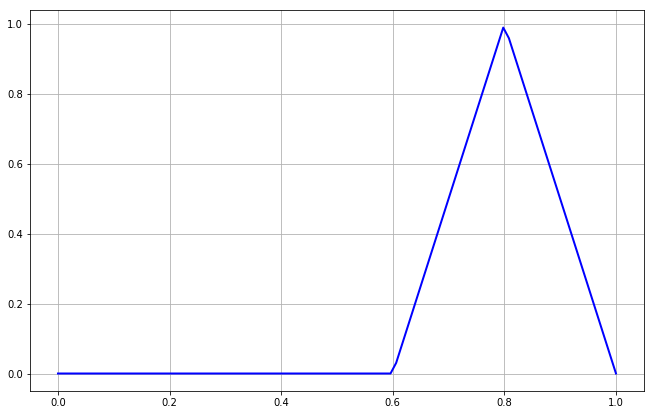

In [4]:
mesh1 = FEMMesh(xL=0., xR=1., numFEs=5)

f = BasisFunction(mesh1, 4)
f.Plot()

## Солверы
Создадим класс-солвер для нахождения коэффициентов методом наименьших квадратов. Данный класс можно использовать в качестве заготовки для создания иерархии классов, в которую будут входить классы-солверы, в которых реализованы методы нахождения коэффициентов:
* метод наименьших квадратов
* интерполяция
* регрессия

In [5]:
class FEMSolverLeastSquares:
    def __init__(self, mesh, function):
        self._mesh = mesh
        self._f = function
        self._numNodes = len(self._mesh.nodes)
        self._BasisFuncs = [BasisFunction(self._mesh, i) \
                            for i in range(self._numNodes)]
        
        self._integrationMethod = TrapeziumMethod()
        self._integrationMethod.SetLeftBorder(self._mesh.nodes[0])
        self._integrationMethod.SetNumBlocks(int(1e2))
    
        
    
    def MassMatrixEntry(self, i, j):
        self._integrationMethod.SetFunction(\
                            lambda t: self._BasisFuncs[i](t)*self._BasisFuncs[j](t) \
                                    )
        return self._integrationMethod(self._mesh.nodes[-1])
    
    
    def LoadVectorEntry(self, i):
        self._integrationMethod.SetFunction(lambda t: self._f(t)*self._BasisFuncs[i](t))
        
        return self._integrationMethod(self._mesh.nodes[-1])
        
    
    def Solve(self):
        self._M = np.zeros((self._numNodes, self._numNodes))
        self._b = np.zeros(self._numNodes)
        
        
        for i in range(self._numNodes):
            # инициализация матрицы масс
            for j in range(self._numNodes):
                self._M[i, j] = self.MassMatrixEntry(i, j)
    
            # инициализация вектора нагрузки
            self._b[i] = self.LoadVectorEntry(i)
        
        # "быстрое" решение СЛАУ методом LU-разложения
        self._c = np.linalg.solve(self._M, self._b)
        

    def EvaluateSolution(self, x):
        basisFuncValues = np.array([f(x) for f in self._BasisFuncs])
        value = np.dot(self._c, basisFuncValues)
        
        return value
    
    
    def PlotSolution(self):
        xL = self._mesh.nodes[0]
        xR = self._mesh.nodes[-1]
        
        xData = np.linspace(xL, xR, 100)
        yData = np.array([self.EvaluateSolution(x) for x in xData])
        
        plt.figure(figsize=(11, 7))
        plt.plot(xData, yData, '-', lw=2, label=self.__class__.__name__)
        plt.legend()
        plt.grid('on')
        plt.show()

### Использование

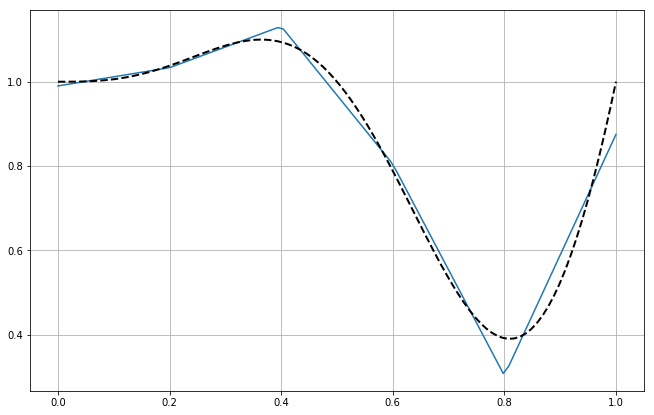

In [6]:
testFunc = lambda t: 1. + (t**2)*np.sin(2.*m.pi*t)
mesh = FEMMesh(0., 1., numFEs=5)


solver = FEMSolverLeastSquares(mesh, testFunc)
solver.Solve()

plt.figure(figsize=(11, 7))
xData = np.linspace(0., 1., 100)
plt.plot(xData, [solver.EvaluateSolution(x) for x in xData])
    
# график аппроксимируемой функции
plt.plot(xData, testFunc(xData), 'k--', lw=2)
plt.grid('on')
plt.show()

## Вопросы?